# Описание проекта

Необходимо предсказать коэффициент восстановления золота из золотосодержащей руды на основе данных с параметрами добычи и очистки

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

In [ ]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### Загрузка данных

In [ ]:
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [ ]:
print('df_full', df_full.shape)
print('df_train', df_train.shape)
print('df_test', df_test.shape)

df_full (19439, 87)
df_train (14149, 87)
df_test (5290, 53)


Вывод: в тестовой выборке отсутствует 34 признака

### Проверка правильности расчёта эффективности обогащения

* C — доля золота в концентрате после флотации/очистки; final.output.concentrate_au

* F — доля золота в сырье/концентрате до флотации/очистки; rougher.input.feed_au

* T — доля золота в отвальных хвостах после флотации/очистки. final.output.tail_au

Recovery = 100 * C * (F-T) / F * (C-T)

In [ ]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [ ]:
recovery = 100*(C*(F - T))/(F*(C - T))

In [ ]:
mae = mean_absolute_error(df_train['rougher.output.recovery'], recovery)

In [ ]:
mae

1.1131451184435918e-14

Вывод: ошибка мала, расчёт эффективности обогащения верный

### Признаки, недоступные в тестовой выборке

In [ ]:
absent_columns = list(set(df_full.columns) - set(df_test.columns))

In [ ]:
absent_columns.sort()
absent_columns

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [ ]:
df_full[df_full.columns.intersection(absent_columns)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                                19439 non-null  float64


Вывод: в тестовой выборке отсутствуют целевые признаки final.output.recovery и rougher.output.recovery

### Предобработка

In [ ]:
# заполнение пропусков предыдущими значениями оправдано,
# поскольку со временем признаки меняются незначительно

df_train = df_train.ffill()
df_test = df_test.ffill()
df_full = df_full.ffill()

In [ ]:
# добавление целевых признаков в тестовую выборку

df_test = df_test.merge(df_full[['date', 'final.output.recovery', 'rougher.output.recovery']], on = 'date')

In [ ]:
df_test.shape

(5290, 55)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5290 non-null   float64
 2   primary_cleaner.input.depressant            5290 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Вывод: в тестовую выборку добавлены целевые признаки, выборки подготовлены к созданию модели

## Анализ данных
### Анализ изменения концентрации металлов Au, Ag, Pb на разных этапах

In [ ]:
metal_au = df_full[["rougher.input.feed_au", "rougher.output.concentrate_au", "primary_cleaner.output.concentrate_au", "final.output.concentrate_au"]]
metal_ag = df_full[["rougher.input.feed_ag", "rougher.output.concentrate_ag", "primary_cleaner.output.concentrate_ag", "final.output.concentrate_ag"]]
metal_pb = df_full[["rougher.input.feed_pb", "rougher.output.concentrate_pb", "primary_cleaner.output.concentrate_pb", "final.output.concentrate_pb"]]

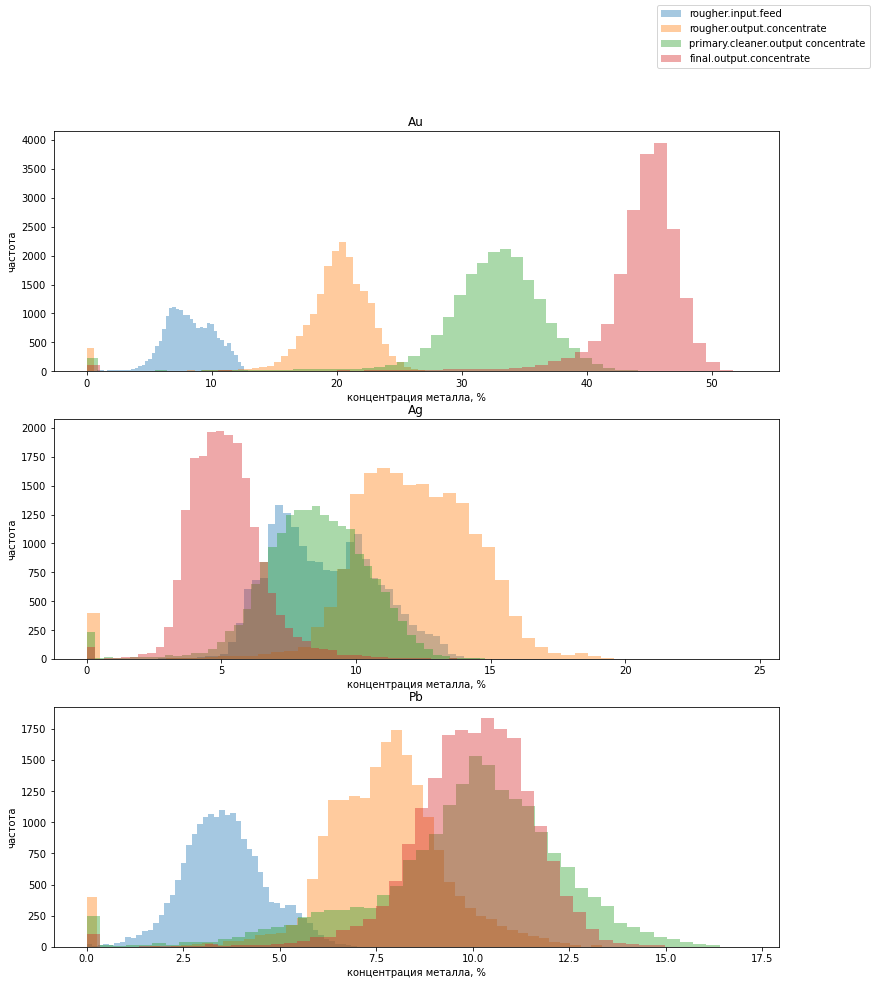

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(13, 15));

for column in list(metal_au):
    sns.distplot(metal_au[column], ax=axes[0], kde=False)
axes[0].set(title="Au", xlabel="концентрация металла, %", ylabel="частота")
for column in list(metal_ag):
    sns.distplot(metal_ag[column], ax=axes[1], kde=False)
axes[1].set(title="Ag", xlabel="концентрация металла, %", ylabel="частота")
for column in list(metal_pb):
    sns.distplot(metal_pb[column], ax=axes[2], kde=False)
axes[2].set(title="Pb", xlabel="концентрация металла, %", ylabel="частота")

fig.legend(["rougher.input.feed", "rougher.output.concentrate", "primary.cleaner.output concentrate", "final.output.concentrate",])
fig.show()

Выводы:
* концентрация Au увеличивается после каждого этапа, что логично, ведь процесс заточен под золото;

* концентрация Ag увеличивается после обогащения, но затем снижается до значений меньше первоначальных;

* концентрация Pb увеличивается при обогащении и очистке, причём после второго этапа очистки распределение сужается при неизменной моде

### Сравнение размера гранул сырья на обучающей и тестовой выборках

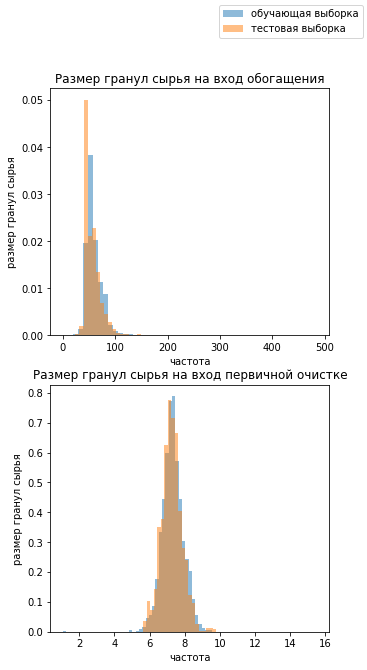

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(5, 10))

axes[0].hist(df_train["rougher.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[0].hist(df_test["rougher.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[0].set(title="Размер гранул сырья на вход обогащения", xlabel="частота", ylabel="размер гранул сырья")

axes[1].hist(df_train["primary_cleaner.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[1].hist(df_test["primary_cleaner.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[1].set(title="Размер гранул сырья на вход первичной очистке", xlabel="частота", ylabel="размер гранул сырья")

fig.legend(["обучающая выборка", "тестовая выборка"])
fig.show()

Вывод: размеры гранул сырья на обучающей и тестовой выборках схожи, следовательно, данные могут быть использованы для создания модели

### Исследование общей концентрации металлов на разных стадиях

In [ ]:
rougher_input = df_full["rougher.input.feed_au"] + df_full["rougher.input.feed_ag"] + df_full["rougher.input.feed_pb"] + df_full["rougher.input.feed_sol"]
rougher_output = df_full["rougher.output.concentrate_au"] + df_full["rougher.output.concentrate_ag"] + df_full["rougher.output.concentrate_pb"] + df_full["rougher.output.concentrate_sol"]
final_output = df_full["final.output.concentrate_au"] + df_full["final.output.concentrate_ag"] + df_full["final.output.concentrate_pb"] + df_full["final.output.concentrate_sol"]

metal_concentrations = pd.DataFrame({'rougher_input':rougher_input, 'rougher_output':rougher_output, 'final_output':final_output})

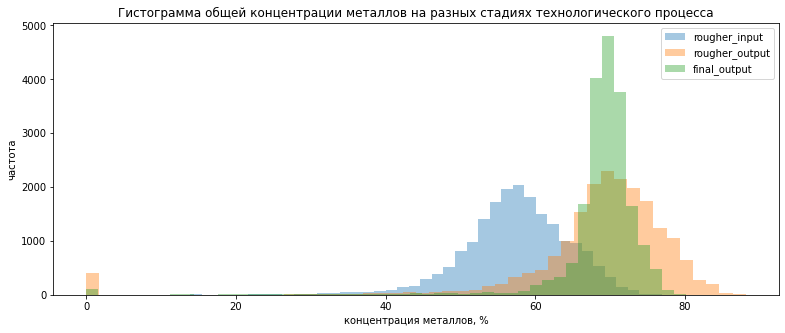

In [ ]:
fig = plt.figure(figsize=(13, 5))

for column in list(metal_concentrations):
    sns.distplot(metal_concentrations[column], kde=False)

plt.legend(list(metal_concentrations))
plt.title("Гистограмма общей концентрации металлов на разных стадиях технологического процесса")
plt.xlabel("концентрация металлов, %")
plt.ylabel("частота")
fig.show()

Вывод: общая концентрация металлов возрастает после обогащения и концентрируется (распределение сужается) в конце технологического процесса

In [ ]:
#КОД РЕВЬЮЕРА
date_rougher = df_full[rougher_input < 0.5]['date']
df_train = df_train.query('date not in @date_rougher')

date_rougher = df_full[rougher_output < 0.5]['date']
df_train = df_train.query('date not in @date_rougher')

date_rougher = df_full[df_full["primary_cleaner.output.concentrate_au"] < 0.5]['date']
df_train = df_train.query('date not in @date_rougher')

date_rougher = df_full[df_full["primary_cleaner.output.concentrate_ag"] < 0.5]['date']
df_train = df_train.query('date not in @date_rougher')

date_rougher = df_full[df_full["primary_cleaner.output.concentrate_pb"] < 0.5]['date']
df_train = df_train.query('date not in @date_rougher')

date_rougher = df_full[final_output < 0.5]['date']
df_train = df_train.query('date not in @date_rougher')

In [ ]:
rougher_input = df_train["rougher.input.feed_au"] + df_train["rougher.input.feed_ag"] + df_train["rougher.input.feed_pb"] + df_train["rougher.input.feed_sol"]
rougher_output = df_train["rougher.output.concentrate_au"] + df_train["rougher.output.concentrate_ag"] + df_train["rougher.output.concentrate_pb"] + df_train["rougher.output.concentrate_sol"]
final_output = df_train["final.output.concentrate_au"] + df_train["final.output.concentrate_ag"] + df_train["final.output.concentrate_pb"] + df_train["final.output.concentrate_sol"]

metal_concentrations = pd.DataFrame({'rougher_input':rougher_input, 'rougher_output':rougher_output, 'final_output':final_output})

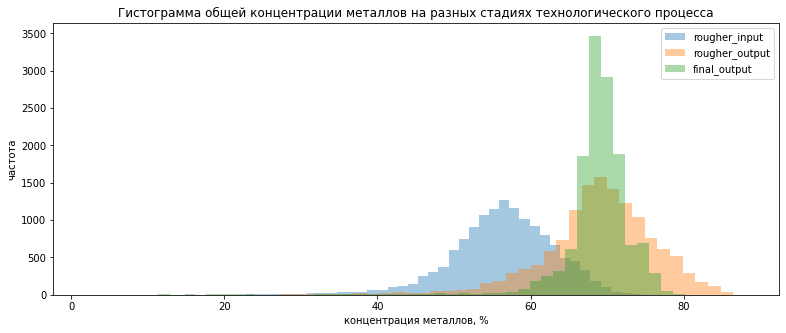

In [ ]:
fig = plt.figure(figsize=(13, 5))

for column in list(metal_concentrations):
    sns.distplot(metal_concentrations[column], kde=False)

plt.legend(list(metal_concentrations))
plt.title("Гистограмма общей концентрации металлов на разных стадиях технологического процесса")
plt.xlabel("концентрация металлов, %")
plt.ylabel("частота")
fig.show()

In [ ]:
metal_au = df_train[["rougher.input.feed_au", "rougher.output.concentrate_au", "primary_cleaner.output.concentrate_au", "final.output.concentrate_au"]]
metal_ag = df_train[["rougher.input.feed_ag", "rougher.output.concentrate_ag", "primary_cleaner.output.concentrate_ag", "final.output.concentrate_ag"]]
metal_pb = df_train[["rougher.input.feed_pb", "rougher.output.concentrate_pb", "primary_cleaner.output.concentrate_pb", "final.output.concentrate_pb"]]

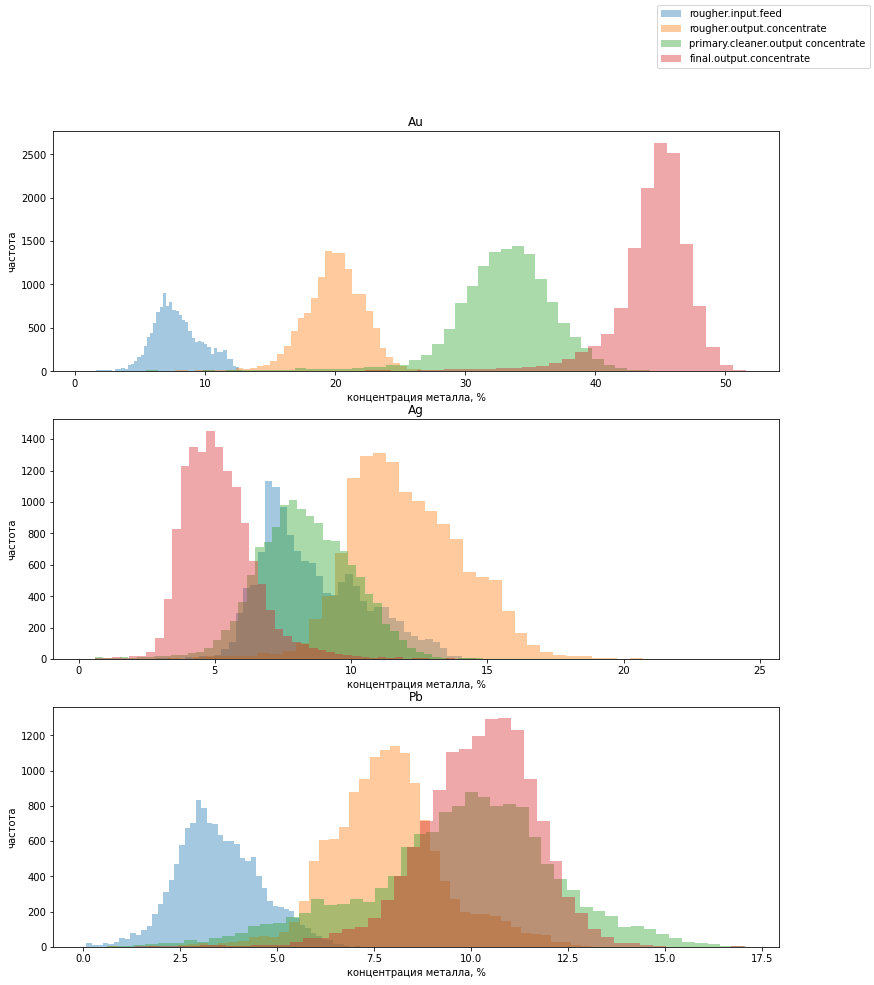

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(13, 15));

for column in list(metal_au):
    sns.distplot(metal_au[column], ax=axes[0], kde=False)
axes[0].set(title="Au", xlabel="концентрация металла, %", ylabel="частота")
for column in list(metal_ag):
    sns.distplot(metal_ag[column], ax=axes[1], kde=False)
axes[1].set(title="Ag", xlabel="концентрация металла, %", ylabel="частота")
for column in list(metal_pb):
    sns.distplot(metal_pb[column], ax=axes[2], kde=False)
axes[2].set(title="Pb", xlabel="концентрация металла, %", ylabel="частота")

fig.legend(["rougher.input.feed", "rougher.output.concentrate", "primary.cleaner.output concentrate", "final.output.concentrate",])
fig.show()

In [ ]:
# в данном случае уберём дату, т.к. скорее всего на качество производства она не влияет

df_train = df_train.drop("date", axis=1)
df_test = df_test.drop("date", axis=1)
df_full = df_full.drop("date", axis=1)

## Модель

Можно идти двумя путями - создавать отдельные модели для каждого из целевых признаков, или для обоих признаков сразу. Выбран первый путь как более простой, однако менее изящный, исходя из временных ограничений

### Функция итоговой sMAPE

In [ ]:
def fsmape(target_actual, target_predictions):
    numerator = np.abs(target_actual - target_predictions)
    denominator = (np.abs(target_actual) + np.abs(target_predictions)) / 2 
    return abs(1 / len(target_actual) * np.sum(numerator / denominator) * 100)

In [ ]:
def fsmape_final(target_rougher, prediction_rougher, target_final, prediction_final):
    smape_final = 0.25*fsmape(target_rougher, prediction_rougher) + 0.75*fsmape(target_final, prediction_final)
    return abs(smape_final)

In [ ]:
# создание метрик из функции. Поскольку они отражают ошибку, то должны снижаться,
# следовательно необходимо указывать greater_is_better = False

smape_scorer = make_scorer(fsmape, greater_is_better = False) 
smape_final_scorer = make_scorer(fsmape_final, greater_is_better = False)

### Обучение моделей

#### Линейная регрессия

In [ ]:
# разделение данных на обучающую и тестовую выборки для каждого из целевых признаков

target_train_rougher = df_train['rougher.output.recovery']
target_train_final = df_train['final.output.recovery']

features_train = df_train.drop(df_train.columns.difference(df_test.columns), axis = 1)
features_train = features_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)

target_test_rougher = df_test['rougher.output.recovery']
target_test_final = df_test['final.output.recovery']

features_test = df_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)

print('target_train_rougher', target_train_rougher.shape)
print('target_train_final', target_train_final.shape)
print('features_train', features_train.shape)

print('target_test_rougher', target_test_rougher.shape)
print('target_test_final', target_test_final.shape)
print('features_test', features_test.shape)

target_train_rougher (13581,)
target_train_final (13581,)
features_train (13581, 52)
target_test_rougher (5290,)
target_test_final (5290,)
features_test (5290, 52)


In [ ]:
# масштабирование не обязательно,
# однако требуется некоторыми код-ревьюерами, исходя из опыта однокурсников

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

features_test = scaler.transform(features_test)

print(features_train.shape)
print(features_test.shape)

(13581, 52)
(5290, 52)


In [ ]:
# кросс-валидация линейной регресии на обучающей выборке
# для прогноза эффективности обогащения чернового концентрата (rougher)

lr_model_rougher = LinearRegression()
scores_rougher = cross_val_score(lr_model_rougher, features_train, target_train_rougher, cv=5, scoring = smape_scorer)
lr_score_rougher = abs(sum(scores_rougher) / len(scores_rougher))
print('Средняя оценка качества модели линейной регрессии sMAPE для lr_model_rougher:', lr_score_rougher)

Средняя оценка качества модели линейной регрессии sMAPE для lr_model_rougher: 7.283471347429938


In [ ]:
# кросс-валидация модели линейной регресии на обучающей выборке
# для прогноза эффективности обогащения финального концентрата (final)

lr_model_final = LinearRegression()
scores_final = cross_val_score(lr_model_final, features_train, target_train_final, cv=5, scoring = smape_scorer)
lr_score_final = abs(sum(scores_final) / len(scores_final))
print('Средняя оценка качества модели линейной регрессии sMAPE для lr_model_final:', lr_score_final)

Средняя оценка качества модели линейной регрессии sMAPE для lr_model_final: 11.007780402962796


In [ ]:
print("Средняя взвешенная оценка качества модели линейной регрессии sMAPE:", 0.25*lr_score_rougher+0.75*lr_score_final)

Средняя взвешенная оценка качества модели линейной регрессии sMAPE: 10.076703139079582


#### Дерево решений

In [ ]:
%%time

dt_model_rougher = DecisionTreeRegressor(random_state=12345)

parameters = {'max_depth': range(1,6),
             'min_samples_leaf': range(1,6),
             'min_samples_split': range(2,10,2)}

grid_rougher = GridSearchCV(dt_model_rougher, parameters, scoring=smape_scorer, cv = 5, n_jobs = -1)
grid_rougher.fit(features_train, target_train_rougher)

print('best_score:%f'%abs(grid_rougher.best_score_))
print('best_parameters:', grid_rougher.best_params_)

best_score:6.736126
best_parameters: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
CPU times: user 1min 59s, sys: 0 ns, total: 1min 59s
Wall time: 2min 2s


In [ ]:
%%time

dt_model_final = DecisionTreeRegressor(random_state=12345)

parameters = {'max_depth': range(1,6),
             'min_samples_leaf': range(1,6),
             'min_samples_split': range(2,10,2)}

grid_final = GridSearchCV(dt_model_final, parameters, scoring=smape_scorer, cv = 5, n_jobs = -1)
grid_final.fit(features_train, target_train_final)

print('best_score:%f'%abs(grid_final.best_score_))
print('best_parameters:', grid_final.best_params_)

best_score:9.215108
best_parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
CPU times: user 2min 2s, sys: 0 ns, total: 2min 2s
Wall time: 2min 2s


In [ ]:
print("Средняя взвешенная оценка качества модели дерева решений sMAPE:", 0.25*abs(grid_rougher.best_score_)+0.75*abs(grid_final.best_score_))

Средняя взвешенная оценка качества модели дерева решений sMAPE: 8.595362556306714


метрика ниже, т.е. лучше, чем у линейной регрессии

#### Случайный лес

In [ ]:
%%time

rf_model_rougher = RandomForestRegressor(random_state=12345)

parameters = {'n_estimators': range(50,101,25),
             'max_depth': range(4,8,1)}


grid_rougher = GridSearchCV(rf_model_rougher, parameters, scoring=smape_scorer, cv = 5, n_jobs = -1)
grid_rougher.fit(features_train, target_train_rougher)

print('best_score:%f'%abs(grid_rougher.best_score_))
print('best_parameters:', grid_rougher.best_params_)

best_score:6.329979
best_parameters: {'max_depth': 6, 'n_estimators': 100}
CPU times: user 18min 21s, sys: 281 ms, total: 18min 22s
Wall time: 18min 37s


In [ ]:
%%time

rf_model_final = RandomForestRegressor(random_state=12345)

parameters = {'n_estimators': range(50,101,25),
             'max_depth': range(4,8,1)}


grid_final = GridSearchCV(rf_model_final, parameters, scoring=smape_scorer, cv = 5, n_jobs = -1)
grid_final.fit(features_train, target_train_final)

print('best_score:%f'%abs(grid_final.best_score_))
print('best_parameters:', grid_final.best_params_)

best_score:8.916202
best_parameters: {'max_depth': 4, 'n_estimators': 50}
CPU times: user 18min 51s, sys: 344 ms, total: 18min 51s
Wall time: 18min 54s


In [ ]:
print("Средняя взвешенная оценка качества модели случайного леса sMAPE:", 0.25*abs(grid_rougher.best_score_)+0.75*abs(grid_final.best_score_))

Средняя взвешенная оценка качества модели случайного леса sMAPE: 8.269646268743637


Вывод: самая низкая метрика sMAPE у модели случайного леса, которая и является наилучшей моделью 

#### Проверка на тестовой выборке

In [ ]:
rf_model_rougher = RandomForestRegressor(n_estimators = 100, max_depth = 6, random_state=12345)

rf_model_rougher.fit(features_train, target_train_rougher)

predictions_test_rougher = rf_model_rougher.predict(features_test)

In [ ]:
score_rougher = fsmape(target_test_rougher, predictions_test_rougher)
print('sMAPE:', score_rougher)

sMAPE: 7.970580900980516


In [ ]:
rf_model_final = RandomForestRegressor(n_estimators = 50, max_depth = 4, random_state=12345)

rf_model_final.fit(features_train, target_train_final)

predictions_test_final = rf_model_final.predict(features_test)

In [ ]:
score_final = fsmape(target_test_final, predictions_test_final)
print('sMAPE:', score_final)

sMAPE: 9.722031623038278


In [ ]:
print("final sMAPE = ", 0.25*score_rougher+0.75*score_final)

final sMAPE =  9.274582826585709


In [ ]:
# dummy-модель

predicted_test_rougher_mean = pd.Series(target_train_rougher.mean(), index = target_test_rougher.index)
predicted_test_final_mean = pd.Series(target_train_final.mean(), index = target_test_final.index)

score_rougher = fsmape(target_test_rougher, predicted_test_rougher_mean)
score_final = fsmape(target_test_final, predicted_test_final_mean)

print("final dummy sMAPE = ", 0.25*score_rougher+0.75*score_final)

final dummy sMAPE =  9.827647160711791


Вывод: Наилучшая модель - модель случайного леса, она прошла проверку на адекватность - по сравнению с константной dummy-моделью она имеет меньшую ошибку sMAPE